In [2]:
pip install pyreadr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.3/418.3 kB 33.4 MB/s eta 0:00:00


In [3]:
import pyreadr
import numpy as np
import pandas as pd
# import packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
#import tensorflow_probability as tfp
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
result =pyreadr.read_r('/content/drive/My Drive/FDBNCRW2008.RData')
data = result["data"]
subj = np.unique(data.subj)
subj
for i in range(subj.shape[0]):
    RT = []
    for cond in ['speed', 'neutral', 'accuracy']:
        sub_data = data.loc[(data.subj == subj[i]) & (data.instruction == cond)]
        RT.append(list(sub_data.loc[sub_data.correct == True].RT))
        RT.append(list(sub_data.loc[sub_data.correct == False].RT))
    rt1 = np.sort(RT[0])
    rt2 = np.sort(RT[1])
    rt3 = np.sort(RT[2])
    rt4 = np.sort(RT[3])
    rt5 = np.sort(RT[4])
    rt6 = np.sort(RT[5])
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
            output_dim=3,
            num_hidden_layers=5,
            num_neurons_per_layer=50,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        ## Define NN architecture
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers-1)]
        self.hidden1 = tf.keras.layers.Dense(num_neurons_per_layer,activation = 'softplus')
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = X
        for i in range(self.num_hidden_layers-1):
            Z = self.hidden[i](Z)
        #Z = self.hidden1(Z)
        return self.out(Z)

class PINNIdentificationNet(PINN_NeuralNet):
    def __init__(self, *args, **kwargs):

        # Call init of base class
        super().__init__(*args,**kwargs)

        # Initialize variable for lambda
                # Initialize variable for lambda
        self.lambd0 = self.add_weight(name="lambd0", initializer="ones" ,trainable=True, dtype=tf.float32)
        self.t_inf1 = self.add_weight(name="t_inf1", initializer= tf.keras.initializers.Constant(3.0) ,trainable=True, dtype=tf.float32)
        self.t_inf2 = self.add_weight(name="t_inf2", initializer= tf.keras.initializers.Constant(3.0) ,trainable=True, dtype=tf.float32)
        self.t_inf3 = self.add_weight(name="t_inf3", initializer= tf.keras.initializers.Constant(3.0) ,trainable=True, dtype=tf.float32)
        self.a1 = self.add_weight(name="a1", initializer= tf.keras.initializers.Constant(3.0) ,trainable=True, dtype=tf.float32)
        self.a2 = self.add_weight(name="a2", initializer= tf.keras.initializers.Constant(3.0) ,trainable=True, dtype=tf.float32)
        self.a3 = self.add_weight(name="a3", initializer= tf.keras.initializers.Constant(3.0) ,trainable=True, dtype=tf.float32)
        self.tt0 = self.add_weight(name="tt0", initializer="ones" ,trainable=True, dtype=tf.float32)
        self.lambd0_list = []
        self.t_inf1_list = []
        self.t_inf2_list = []
        self.t_inf3_list = []
        self.a1_list = []
        self.a2_list = []
        self.a3_list = []
        self.tt0_list = []

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=False) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            s = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            u = s[:,0:1]
            v = s[:,1:2]
            f = s[:,2:3]

            u_x = tape.gradient(u, self.x)
            v_x = tape.gradient(v, self.x)
            f_x = tape.gradient(f, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        v_t = tape.gradient(v, self.t)
        v_xx = tape.gradient(v_x, self.x)
        f_t = tape.gradient(f, self.t)
        f_xx = tape.gradient(f_x, self.x)

        del tape
        return self.fun_r1(self.t, self.x, u, u_t, u_x, u_xx), self.fun_r2(self.t, self.x, v, v_t, v_x, v_xx), self.fun_r3(self.t, self.x, f, f_t, f_x, f_xx)

    def loss_fn(self, X,xmax,rt1,rt2, rt3,rt4,rt5,rt6,u):
        # Compute phi_r
        r1, r2, r3= self.get_r()
        phi_r1 = tf.reduce_mean(tf.square(r1))
        phi_r2 = tf.reduce_mean(tf.square(r2))
        phi_r3 = tf.reduce_mean(tf.square(r3))
        # Initialize loss
        loss_r = phi_r1 + phi_r2 + phi_r3

        # Add phi_0 and phi_b to the loss

        u_pred = self.model(X[0])
        loss_0 = tf.reduce_mean(tf.square(u[0] - u_pred[:,0:1])) + tf.reduce_mean(tf.square(u[0] - u_pred[:,1:2])) +  tf.reduce_mean(tf.square(u[0] - u_pred[:,2:3]))

        u_pred = self.model(X[1])
        loss_b = tf.reduce_mean(tf.square(u[1] - u_pred[:,0:1])) + tf.reduce_mean(tf.square(u[1] - u_pred[:,1:2])) + tf.reduce_mean(tf.square(u[1] - u_pred[:,2:3]))

        tspace1 = np.sort(rt1)
        tspace2 = np.sort(rt2)
        tspace3 = np.sort(rt3)
        tspace4 = np.sort(rt4)
        tspace5 = np.sort(rt5)
        tspace6 = np.sort(rt6)
        minRT1 = min(rt1)
        minRT2 = min(rt2)
        minRT3 = min(rt3)
        minRT4 = min(rt4)
        minRT5 = min(rt5)
        minRT6 = min(rt6)
        self.minRT = min(minRT1,minRT2,minRT3,minRT4,minRT5,minRT6)

        tspace_tf1 = tf.constant(tspace1.reshape((len(rt1),1)),'float32')
        t1 = tspace_tf1 - tf.math.sigmoid(self.model.tt0)*self.minRT

        xspace = np.ones((len(tspace1),1))*xmax
        xtf = tf.constant(xspace,'float32')
        X = tf.concat([t1,xtf],1)
        p_i =  self.model(X)[:,0:1]

        xspace1 = np.ones((len(tspace1),1))*(xmax-0.02)
        xtf1 = tf.constant(xspace1,'float32')
        X1 = tf.concat([t1,xtf1],1)
        p_ii =  self.model(X1)[:,0:1]

        xspace2 = np.ones((len(tspace1),1))*(xmax-0.04)
        xtf2 = tf.constant(xspace2,'float32')
        X2 = tf.concat([t1,xtf2],1)
        p_iii =  self.model(X2)[:,0:1]
        bt1 = self.model.a1 - (self.model.a1*t1)/(2*self.model.t_inf1)
        mu1 =  tf.nn.softplus(self.model.lambd0)/bt1 - (xmax*(-self.model.a1/(2*self.model.t_inf1)))/bt1
        ddx = xmax*bt1 - (xmax-0.02)*bt1
        p_x = (3*p_i-4*p_ii+p_iii)/(2*ddx)
        J1 = mu1* p_i -0.5*p_x

        #J1 = (tf.nn.softplus(self.model.lambd0) + (tf.nn.softplus(self.model.lambd1)*t1)/(t1+self.model.tau))* p_i -0.5*(self.model.sig0)**2*p_x
        kde1 = gaussian_kde(tspace1)
        p_kde1 = len(tspace1)*kde1(tspace1)[:, np.newaxis]/(len(tspace2)+len(tspace1))
        p_kde_tensor1 = tf.convert_to_tensor(p_kde1, dtype=tf.float32)
        KDE_loss1 = tf.reduce_mean(tf.square(J1 - p_kde_tensor1))


        tspace_tf2 = tf.constant(tspace2.reshape((len(rt2),1)),'float32')

        t2 = tspace_tf2 - tf.math.sigmoid(self.model.tt0)*self.minRT


        xspace20 = np.ones((len(tspace2),1))*(-xmax)
        xtf20 = tf.constant(xspace20,'float32')
        X20 = tf.concat([t2,xtf20],1)
        p_i2 =  self.model(X20)[:,0:1]

        xspace21 = np.ones((len(tspace2),1))*(-xmax+0.02)
        xtf21 = tf.constant(xspace21,'float32')
        X21 = tf.concat([t2,xtf21],1)
        p_ii2 =  self.model(X21)[:,0:1]

        xspace22 = np.ones((len(tspace2),1))*(-xmax+0.04)
        xtf22 = tf.constant(xspace22,'float32')
        X22 = tf.concat([t2,xtf22],1)
        p_iii2 =  self.model(X22)[:,0:1]
        bt2 = self.model.a1 - (self.model.a1*t2)/(2*self.model.t_inf1)
        mu2 =  tf.nn.softplus(self.model.lambd0)/bt2 - (-xmax*(-self.model.a1/(2*self.model.t_inf1)))/bt2
        dddx = xmax*bt2 - (xmax-0.02)*bt2

        p_x2 = (-3*p_i2+4*p_ii2 -p_iii2)/(2*dddx)

        J2 = mu2* p_i2 -0.5*p_x2

        #J2 =(tf.nn.softplus(self.model.lambd0) + (tf.nn.softplus(self.model.lambd1)*t2)/(t2+self.model.tau))* p_i2 -0.5*(self.model.sig0)**2*p_x2
        kde2 = gaussian_kde(tspace2)
        p_kde2 =- len(tspace2)*kde2(tspace2)[:, np.newaxis]/(len(tspace2)+len(tspace1))
        p_kde_tensor2 = tf.convert_to_tensor(p_kde2, dtype=tf.float32)
        KDE_loss2 = tf.reduce_mean(tf.square(J2 - p_kde_tensor2))
######################################################################################################################## 2

        tspace_tf1 = tf.constant(tspace3.reshape((len(rt3),1)),'float32')
        t1 = tspace_tf1 - tf.math.sigmoid(self.model.tt0)*self.minRT

        xspace = np.ones((len(tspace3),1))*xmax
        xtf = tf.constant(xspace,'float32')
        X = tf.concat([t1,xtf],1)
        p_i =  self.model(X)[:,1:2]

        xspace1 = np.ones((len(tspace3),1))*(xmax-0.02)
        xtf1 = tf.constant(xspace1,'float32')
        X1 = tf.concat([t1,xtf1],1)
        p_ii =  self.model(X1)[:,1:2]

        xspace2 = np.ones((len(tspace3),1))*(xmax-0.04)
        xtf2 = tf.constant(xspace2,'float32')
        X2 = tf.concat([t1,xtf2],1)
        p_iii =  self.model(X2)[:,1:2]
        bt3 = self.model.a2 - (self.model.a2*t1)/(2*self.model.t_inf2)
        mu3 =  tf.nn.softplus(self.model.lambd0)/bt3 - (xmax*(-self.model.a2/(2*self.model.t_inf2)))/bt3
        ddx = xmax*bt3 - (xmax-0.02)*bt3
        p_x = (3*p_i-4*p_ii+p_iii)/(2*ddx)
        J1 = mu3* p_i -0.5*p_x
        #J1 = (tf.nn.softplus(self.model.lambd0) + (tf.nn.softplus(self.model.lambd1)*t1)/(t1+self.model.tau))* p_i -0.5*(self.model.sig1)**2*p_x
        kde1 = gaussian_kde(tspace3)
        p_kde1 = len(tspace3)*kde1(tspace3)[:, np.newaxis]/(len(tspace3)+len(tspace4))
        p_kde_tensor1 = tf.convert_to_tensor(p_kde1, dtype=tf.float32)
        KDE_loss3 = tf.reduce_mean(tf.square(J1 - p_kde_tensor1))


        tspace_tf2 = tf.constant(tspace4.reshape((len(rt4),1)),'float32')

        t2 = tspace_tf2 - tf.math.sigmoid(self.model.tt0)*self.minRT


        xspace20 = np.ones((len(tspace4),1))*(-xmax)
        xtf20 = tf.constant(xspace20,'float32')
        X20 = tf.concat([t2,xtf20],1)
        p_i2 =  self.model(X20)[:,1:2]

        xspace21 = np.ones((len(tspace4),1))*(-xmax+0.02)
        xtf21 = tf.constant(xspace21,'float32')
        X21 = tf.concat([t2,xtf21],1)
        p_ii2 =  self.model(X21)[:,1:2]

        xspace22 = np.ones((len(tspace4),1))*(-xmax+0.04)
        xtf22 = tf.constant(xspace22,'float32')
        X22 = tf.concat([t2,xtf22],1)
        p_iii2 =  self.model(X22)[:,1:2]
        bt4 = self.model.a2 - (self.model.a2*t2)/(2*self.model.t_inf2)
        mu4 =  tf.nn.softplus(self.model.lambd0)/bt4 - (-xmax*(-self.model.a2/(2*self.model.t_inf2)))/bt4
        dddx = xmax*bt4 - (xmax-0.02)*bt4

        p_x2 = (-3*p_i2+4*p_ii2 -p_iii2)/(2*dddx)

        J2 = mu4* p_i2 -0.5*p_x2
        #J2 = (tf.nn.softplus(self.model.lambd0) + (tf.nn.softplus(self.model.lambd1)*t2)/(t2+self.model.tau))* p_i2 -0.5*(self.model.sig1)**2*p_x2
        kde2 = gaussian_kde(tspace4)
        p_kde2 =- len(tspace4)*kde2(tspace4)[:, np.newaxis]/(len(tspace3)+len(tspace4))
        p_kde_tensor2 = tf.convert_to_tensor(p_kde2, dtype=tf.float32)
        KDE_loss4 = tf.reduce_mean(tf.square(J2 - p_kde_tensor2))

  #####################################################################################################################3

        tspace_tf1 = tf.constant(tspace5.reshape((len(rt5),1)),'float32')
        t1 = tspace_tf1 - tf.math.sigmoid(self.model.tt0)*self.minRT

        xspace = np.ones((len(tspace5),1))*xmax
        xtf = tf.constant(xspace,'float32')
        X = tf.concat([t1,xtf],1)
        p_i =  self.model(X)[:,2:3]

        xspace1 = np.ones((len(tspace5),1))*(xmax-0.02)
        xtf1 = tf.constant(xspace1,'float32')
        X1 = tf.concat([t1,xtf1],1)
        p_ii =  self.model(X1)[:,2:3]

        xspace2 = np.ones((len(tspace5),1))*(xmax-0.04)
        xtf2 = tf.constant(xspace2,'float32')
        X2 = tf.concat([t1,xtf2],1)
        p_iii =  self.model(X2)[:,2:3]
        bt5 = self.model.a3 - (self.model.a3*t1)/(2*self.model.t_inf3)
        mu5 =  tf.nn.softplus(self.model.lambd0)/bt5 - (xmax*(-self.model.a3/(2*self.model.t_inf3)))/bt5
        ddx = xmax*bt5 - (xmax-0.02)*bt5
        p_x = (3*p_i-4*p_ii+p_iii)/(2*ddx)
        J1 = mu5* p_i -0.5*p_x

        #J1 = (tf.nn.softplus(self.model.lambd0) + (tf.nn.softplus(self.model.lambd1)*t1)/(t1+self.model.tau))* p_i -0.5*(self.model.sig2)**2*p_x
        kde1 = gaussian_kde(tspace5)
        p_kde1 = len(tspace5)*kde1(tspace5)[:, np.newaxis]/(len(tspace5)+len(tspace6))
        p_kde_tensor1 = tf.convert_to_tensor(p_kde1, dtype=tf.float32)
        KDE_loss5 = tf.reduce_mean(tf.square(J1 - p_kde_tensor1))


        tspace_tf2 = tf.constant(tspace6.reshape((len(rt6),1)),'float32')

        t2 = tspace_tf2 - tf.math.sigmoid(self.model.tt0)*self.minRT


        xspace20 = np.ones((len(tspace6),1))*(-xmax)
        xtf20 = tf.constant(xspace20,'float32')
        X20 = tf.concat([t2,xtf20],1)
        p_i2 =  self.model(X20)[:,2:3]

        xspace21 = np.ones((len(tspace6),1))*(-xmax+0.02)
        xtf21 = tf.constant(xspace21,'float32')
        X21 = tf.concat([t2,xtf21],1)
        p_ii2 =  self.model(X21)[:,2:3]

        xspace22 = np.ones((len(tspace6),1))*(-xmax+0.04)
        xtf22 = tf.constant(xspace22,'float32')
        X22 = tf.concat([t2,xtf22],1)
        p_iii2 =  self.model(X22)[:,2:3]
        bt6 = self.model.a3 - (self.model.a3*t2)/(2*self.model.t_inf3)
        mu6 =  tf.nn.softplus(self.model.lambd0)/bt6 - (-xmax*(-self.model.a3/(2*self.model.t_inf3)))/bt6
        dddx = xmax*bt6 - (xmax-0.02)*bt6

        p_x2 = (-3*p_i2+4*p_ii2 -p_iii2)/(2*dddx)

        J2 = mu6* p_i2 -0.5*p_x2

        #J2 =(tf.nn.softplus(self.model.lambd0) + (tf.nn.softplus(self.model.lambd1)*t2)/(t2+self.model.tau))* p_i2 -0.5*(self.model.sig2)**2*p_x2
        kde2 = gaussian_kde(tspace6)
        p_kde2 =- len(tspace6)*kde2(tspace6)[:, np.newaxis]/(len(tspace5)+len(tspace6))
        p_kde_tensor2 = tf.convert_to_tensor(p_kde2, dtype=tf.float32)
        KDE_loss6 = tf.reduce_mean(tf.square(J2 - p_kde_tensor2))


        return 1*(loss_r+loss_0+loss_b) + KDE_loss1 + KDE_loss2 + KDE_loss3 + KDE_loss4 + KDE_loss5 + KDE_loss6


    def get_grad(self, X,xmax,rt1,rt2,rt3,rt4,rt5,rt6, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            #tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X,xmax,rt1,rt2,rt3,rt4,rt5,rt6, u)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        return loss, g

    #def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
     #   return u_t + tf.nn.softplus(self.model.lambd)*u_x - 0.5 *(tf.nn.softplus(self.model.sig))**2* u_xx

    def solve_with_TFoptimizer(self, optimizer, X,xmax,rt1,rt2,rt3,rt4,rt5,rt6, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X,xmax,rt1,rt2,rt3,rt4,rt5,rt6, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X,rt, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape

                # Weight matrices
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, 'float32'))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X,rt, u)

            # Store current loss for callback function
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            # Return value and gradient of \phi as tuple
            return loss, grad_flat


        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1


    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,'float32'))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

class F_P_PINNSolver(PINNSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            s = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            u = s[:,0:1]
            v = s[:,1:2]
            f = s[:,2:3]
            u_x = tape.gradient(u, self.x)
            v_x = tape.gradient(v, self.x)
            f_x = tape.gradient(f, self.x)
        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        v_t = tape.gradient(v, self.t)
        v_xx = tape.gradient(v_x, self.x)
        f_t = tape.gradient(f, self.t)
        f_xx = tape.gradient(f_x, self.x)
        del tape

        return self.fun_r1(self.t, self.x, u, u_t, u_x,u_xx),self.fun_r2(self.t, self.x, v, v_t, v_x,v_xx),self.fun_r3(self.t, self.x, f, f_t, f_x,f_xx)

class F_P_PINNIdentification(F_P_PINNSolver):

    def fun_r1(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        # Define residual of the PDE
        bt0 = self.model.a1 - (self.model.a1*t)/(2*self.model.t_inf3)
        mu0 = tf.nn.softplus(self.model.lambd0)/bt0 - (x*(-self.model.a1/(2*self.model.t_inf3)))/bt0
        return u_t + mu0*u_x - 0.5 *(1/bt0)**2* u_xx
    def fun_r2(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        # Define residual of the PDE
        bt0 = self.model.a2 - (self.model.a2*t)/(2*self.model.t_inf2)
        mu0 = tf.nn.softplus(self.model.lambd0)/bt0 - (x*(-self.model.a2/(2*self.model.t_inf2)))/bt0
        return u_t + mu0*u_x - 0.5 *(1/bt0)**2* u_xx

    def fun_r3(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        # Define residual of the PDE
        bt0 = self.model.a3 - (self.model.a3*t)/(2*self.model.t_inf3)
        mu0 = tf.nn.softplus(self.model.lambd0)/bt0 - (x*(-self.model.a3/(2*self.model.t_inf3)))/bt0
        return u_t + mu0*u_x - 0.5 *(1/bt0)**2* u_xx
        #return u_t + (tf.nn.softplus(self.model.lambd0) + (tf.nn.softplus(self.model.lambd1)*t)/(t+self.model.tau))*u_x - 0.5 *(self.model.sig2)**2* u_xx

    def callback(self, xr=None):
        v_0 = tf.nn.softplus(self.model.lambd0).numpy()
        a1 = self.model.a1.numpy()
        a2 = self.model.a2.numpy()
        a3 = self.model.a3.numpy()
        t_inf1 = self.model.t_inf1.numpy()
        t_inf2 = self.model.t_inf2.numpy()
        t_inf3 = self.model.t_inf3.numpy()
        tt0 =(tf.math.sigmoid(self.model.tt0)*self.minRT).numpy()
        self.model.lambd0_list.append(v_0)
        self.model.a1_list.append(a1)
        self.model.a2_list.append(a2)
        self.model.a3_list.append(a3)
        self.model.t_inf1_list.append(t_inf1)
        self.model.t_inf2_list.append(t_inf2)
        self.model.t_inf3_list.append(t_inf3)
        self.model.tt0_list.append(tt0)
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e} drift = {:10.8e}  T_01 = {:10.8e} T_02 = {:10.8e} T_03 = {:10.8e} a1 = {:10.8e} a2 = {:10.8e} a3 = {:10.8e}  t0 = {:10.8e}'.format(self.iter, self.current_loss, v_0, t_inf1,t_inf2, t_inf3,a1,a2,a3, tt0))

        self.hist.append(self.current_loss)
        self.iter += 1

    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.plot(range(len(self.hist)), self.model.lambd_list,'-',color=color)
        ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color=color)
        return (ax1,ax2)
    def lambda0f(self):
      mu = tf.nn.softplus(self.model.lambd0)
      return mu.numpy()


    def t_inff1(self):
      return self.model.t_inf1.numpy()

    def t_inff2(self):
      return self.model.t_inf2.numpy()

    def t_inff3(self):
      return self.model.t_inf3.numpy()

    def a1f(self):
        a= self.model.a1
        return a.numpy()
    def a2f(self):
        a= self.model.a2
        return a.numpy()
    def a3f(self):
        a= self.model.a3
        return a.numpy()

    def tt0f(self):
            return (tf.math.sigmoid(self.model.tt0)*self.minRT).numpy()

rt1 = np.sort(rt1)
rt2 = np.sort(rt2)
rt3 = np.sort(rt3)
rt4 = np.sort(rt4)
rt5 = np.sort(rt5)
rt6 = np.sort(rt6)



RT1 = rt1
RT2 = rt2
RT3 = rt3
RT4 = rt4
RT5 = rt5
RT6 = rt6
threshold = 1
epoch = 20000
# Mesh Grid
N = 100
xmax = 1
#xmax = threshold
max1 = max(RT1)
xmin = -xmax
lb = [0, xmin]
maxrt1 = max(RT1)
maxrt2 = max(RT2)
maxrt3 = max(RT3)
maxrt4 = max(RT4)
maxrt5 = max(RT5)
maxrt6 = max(RT6)
ub = [max(maxrt1,maxrt2,maxrt3,maxrt4,maxrt5,maxrt6),xmax]
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T
Xgrid = tf.constant(Xgrid,'float32')




# Boundary data
N_b = 500
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype='float32')
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype='float32')
X_b = tf.concat([t_b, x_b], axis=1)
X_b
u_b = tf.zeros(tf.shape(x_b),'float32')


delta = 7.8*10**(-2)

# direct’s delta function
def ddf(x,delta,x0):
    return 1/(2*np.sqrt(np.pi*delta))*tf.math.exp(-((x-x0)**2)/(4*delta))

# Define initial condition
def fun_u_0(x):
    return ddf(x,delta,0)


N_0 = 50
t_0 = tf.ones((N_0,1), dtype='float32')*lb[0]    #t = 0
x_0 = np.linspace(lb[1], ub[1], N_0-1, dtype='float32')
x_0 = np.asarray(list(x_0) + [0.0])
x_0 = np.sort(x_0)
#u_0 = np.where(x_0==0,1,0)
#uu_0 = 2.5*smooth(u_0, 1)
x_0 = tf.convert_to_tensor(x_0,dtype='float32')
x_0 = tf.reshape(x_0 ,[N_0,1])
u_0 = fun_u_0(x_0)
#plt.plot(x_0,u_0)

X_0 = tf.concat([t_0, x_0], axis=1)

X_param = [X_0,X_b]
u_param = [u_0, u_b]

# dtype in Tensorflow
lb = tf.constant([0, xmin],dtype='float32')
ub = tf.constant([max(maxrt1,maxrt2,maxrt3,maxrt4,maxrt5,maxrt6),xmax],dtype='float32')

# Initialize model
model = PINNIdentificationNet(lb, ub, num_hidden_layers=4,num_neurons_per_layer=30,output_dim =3,
                                        activation='tanh',kernel_initializer='glorot_normal')

model.build(input_shape=(None,2))
# Initilize solver
f_p_Identification = F_P_PINNIdentification(model, Xgrid)

# Choose step sizes aka learning rate
lr =  tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,15000],[0.05,0.001,0.0005])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr) ####################################

# Start timer
t0 = time()
f_p_Identification.solve_with_TFoptimizer(optim, X_param ,xmax,RT1,RT2,RT3,RT4,RT5,RT6, u_param, N=epoch)
print('\nComputation time: {} seconds'.format(time()-t0))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'pinn_identification_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


It 00000: loss = 2.11180401e+01 drift = 1.27695823e+00  T_01 = 3.04999113e+00 T_02 = 2.95000386e+00 T_03 = 3.04999638e+00 a1 = 3.04999757e+00 a2 = 2.95000219e+00 a3 = 3.04999828e+00  t0 = 1.85563996e-01
It 00050: loss = 5.22933292e+00 drift = 2.87210655e+00  T_01 = 1.52084816e+00 T_02 = 1.07344019e+00 T_03 = 1.06481326e+00 a1 = 1.09860289e+00 a2 = 1.28275990e+00 a3 = 1.39947307e+00  t0 = 1.69170946e-01
It 00100: loss = 5.70295691e-01 drift = 3.32789493e+00  T_01 = 1.73656213e+00 T_02 = 8.16814899e-01 T_03 = 9.25542057e-01 a1 = 8.88611317e-01 a2 = 1.21471715e+00 a3 = 1.34482563e+00  t0 = 1.79061428e-01
It 00150: loss = 1.53575790e+00 drift = 3.56914258e+00  T_01 = 1.80726135e+00 T_02 = 7.41518915e-01 T_03 = 8.92800808e-01 a1 = 8.95447969e-01 a2 = 1.32823944e+00 a3 = 1.39068794e+00  t0 = 1.95676193e-01
It 00200: loss = 9.44207191e-01 drift = 3.75209212e+00  T_01 = 1.82352543e+00 T_02 = 7.65052497e-01 T_03 = 9.47951317e-01 a1 = 9.16388452e-01 a2 = 1.37726533e+00 a3 = 1.50958765e+00  t0 = 

KeyboardInterrupt: 

In [3]:
import pyreadr
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.optimize import minimize

result = pyreadr.read_r('/content/drive/My Drive/FDBNCRW2008.RData')
data = result["data"]
subj = np.unique(data.subj)

for i in range(subj.shape[0]):
    RT = []
    for cond in ['speed', 'neutral', 'accuracy']:
        sub_data = data.loc[(data.subj == subj[i]) & (data.instruction == cond)]
        RT.append(list(sub_data.loc[data.correct == True].RT))
        RT.append(list(sub_data.loc[data.correct == False].RT))
    rt1 = np.sort(RT[0])
    rt2 = np.sort(RT[1])
    rt3 = np.sort(RT[2])
    rt4 = np.sort(RT[3])
    rt5 = np.sort(RT[4])
    rt6 = np.sort(RT[5])

class TINN_NeuralNet(tf.keras.Model):
    def __init__(self, lb, ub,
            output_dim=3,
            num_hidden_layers=5,
            num_neurons_per_layer=50,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers-1)]
        self.hidden1 = tf.keras.layers.Dense(num_neurons_per_layer, activation='softplus')
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        Z = X
        for i in range(self.num_hidden_layers-1):
            Z = self.hidden[i](Z)
        return self.out(Z)

class TINNIdentificationNet(TINN_NeuralNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args,**kwargs)

        self.lambd0 = self.add_weight(name="lambd0", initializer="ones", trainable=True, dtype=tf.float32)
        self.t_inf1 = self.add_weight(name="t_inf1", initializer=tf.keras.initializers.Constant(3.0), trainable=True, dtype=tf.float32)
        self.t_inf2 = self.add_weight(name="t_inf2", initializer=tf.keras.initializers.Constant(3.0), trainable=True, dtype=tf.float32)
        self.t_inf3 = self.add_weight(name="t_inf3", initializer=tf.keras.initializers.Constant(3.0), trainable=True, dtype=tf.float32)
        self.a1 = self.add_weight(name="a1", initializer=tf.keras.initializers.Constant(3.0), trainable=True, dtype=tf.float32)
        self.a2 = self.add_weight(name="a2", initializer=tf.keras.initializers.Constant(3.0), trainable=True, dtype=tf.float32)
        self.a3 = self.add_weight(name="a3", initializer=tf.keras.initializers.Constant(3.0), trainable=True, dtype=tf.float32)
        self.tt0 = self.add_weight(name="tt0", initializer="ones", trainable=True, dtype=tf.float32)
        self.lambd0_list = []
        self.t_inf1_list = []
        self.t_inf2_list = []
        self.t_inf3_list = []
        self.a1_list = []
        self.a2_list = []
        self.a3_list = []
        self.tt0_list = []

class TINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]
        self.hist = []
        self.iter = 0

    def get_r(self):
        with tf.GradientTape(persistent=False) as tape:
            tape.watch(self.t)
            tape.watch(self.x)
            s = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            u = s[:,0:1]
            v = s[:,1:2]
            f = s[:,2:3]
            u_x = tape.gradient(u, self.x)
            v_x = tape.gradient(v, self.x)
            f_x = tape.gradient(f, self.x)
        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        v_t = tape.gradient(v, self.t)
        v_xx = tape.gradient(v_x, self.x)
        f_t = tape.gradient(f, self.t)
        f_xx = tape.gradient(f_x, self.x)
        del tape
        return self.fun_r1(self.t, self.x, u, u_t, u_x, u_xx), self.fun_r2(self.t, self.x, v, v_t, v_x, v_xx), self.fun_r3(self.t, self.x, f, f_t, f_x, f_xx)

    def loss_fn(self, X, xmax, rt1, rt2, rt3, rt4, rt5, rt6, u):
        r1, r2, r3 = self.get_r()
        phi_r1 = tf.reduce_mean(tf.square(r1))
        phi_r2 = tf.reduce_mean(tf.square(r2))
        phi_r3 = tf.reduce_mean(tf.square(r3))
        loss_r = phi_r1 + phi_r2 + phi_r3

        u_pred = self.model(X[0])
        loss_0 = tf.reduce_mean(tf.square(u[0] - u_pred[:,0:1])) + tf.reduce_mean(tf.square(u[0] - u_pred[:,1:2])) + tf.reduce_mean(tf.square(u[0] - u_pred[:,2:3]))

        u_pred = self.model(X[1])
        loss_b = tf.reduce_mean(tf.square(u[1] - u_pred[:,0:1])) + tf.reduce_mean(tf.square(u[1] - u_pred[:,1:2])) + tf.reduce_mean(tf.square(u[1] - u_pred[:,2:3]))

        tspace1 = np.sort(rt1)
        tspace2 = np.sort(rt2)
        tspace3 = np.sort(rt3)
        tspace4 = np.sort(rt4)
        tspace5 = np.sort(rt5)
        tspace6 = np.sort(rt6)
        minRT1 = min(rt1)
        minRT2 = min(rt2)
        minRT3 = min(rt3)
        minRT4 = min(rt4)
        minRT5 = min(rt5)
        minRT6 = min(rt6)
        self.minRT = min(minRT1, minRT2, minRT3, minRT4, minRT5, minRT6)

        tspace_tf1 = tf.constant(tspace1.reshape((len(rt1),1)), 'float32')
        t1 = tspace_tf1 - tf.math.sigmoid(self.model.tt0)*self.minRT
        xspace = np.ones((len(tspace1),1))*xmax
        xtf = tf.constant(xspace, 'float32')
        X = tf.concat([t1, xtf], 1)
        p_i = self.model(X)[:,0:1]
        xspace1 = np.ones((len(tspace1),1))*(xmax-0.02)
        xtf1 = tf.constant(xspace1, 'float32')
        X1 = tf.concat([t1, xtf1], 1)
        p_ii = self.model(X1)[:,0:1]
        xspace2 = np.ones((len(tspace1),1))*(xmax-0.04)
        xtf2 = tf.constant(xspace2, 'float32')
        X2 = tf.concat([t1, xtf2], 1)
        p_iii = self.model(X2)[:,0:1]
        bt1 = self.model.a1 - (self.model.a1*t1)/(2*self.model.t_inf1)
        mu1 = tf.nn.softplus(self.model.lambd0)/bt1 - (xmax*(-self.model.a1/(2*self.model.t_inf1)))/bt1
        ddx = xmax*bt1 - (xmax-0.02)*bt1
        p_x = (3*p_i-4*p_ii+p_iii)/(2*ddx)
        J1 = mu1 * p_i - 0.5*p_x
        kde1 = gaussian_kde(tspace1)
        p_kde1 = len(tspace1)*kde1(tspace1)[:, np.newaxis]/(len(tspace2)+len(tspace1))
        p_kde_tensor1 = tf.convert_to_tensor(p_kde1, dtype=tf.float32)
        KDE_loss1 = tf.reduce_mean(tf.square(J1 - p_kde_tensor1))

        tspace_tf2 = tf.constant(tspace2.reshape((len(rt2),1)), 'float32')
        t2 = tspace_tf2 - tf.math.sigmoid(self.model.tt0)*self.minRT
        xspace20 = np.ones((len(tspace2),1))*(-xmax)
        xtf20 = tf.constant(xspace20, 'float32')
        X20 = tf.concat([t2, xtf20], 1)
        p_i2 = self.model(X20)[:,0:1]
        xspace21 = np.ones((len(tspace2),1))*(-xmax+0.02)
        xtf21 = tf.constant(xspace21, 'float32')
        X21 = tf.concat([t2, xtf21], 1)
        p_ii2 = self.model(X21)[:,0:1]
        xspace22 = np.ones((len(tspace2),1))*(-xmax+0.04)
        xtf22 = tf.constant(xspace22, 'float32')
        X22 = tf.concat([t2, xtf22], 1)
        p_iii2 = self.model(X22)[:,0:1]
        bt2 = self.model.a1 - (self.model.a1*t2)/(2*self.model.t_inf1)
        mu2 = tf.nn.softplus(self.model.lambd0)/bt2 - (-xmax*(-self.model.a1/(2*self.model.t_inf1)))/bt2
        dddx = xmax*bt2 - (xmax-0.02)*bt2
        p_x2 = (-3*p_i2+4*p_ii2-p_iii2)/(2*dddx)
        J2 = mu2 * p_i2 - 0.5*p_x2
        kde2 = gaussian_kde(tspace2)
        p_kde2 = -len(tspace2)*kde2(tspace2)[:, np.newaxis]/(len(tspace2)+len(tspace1))
        p_kde_tensor2 = tf.convert_to_tensor(p_kde2, dtype=tf.float32)
        KDE_loss2 = tf.reduce_mean(tf.square(J2 - p_kde_tensor2))

        tspace_tf1 = tf.constant(tspace3.reshape((len(rt3),1)), 'float32')
        t1 = tspace_tf1 - tf.math.sigmoid(self.model.tt0)*self.minRT
        xspace = np.ones((len(tspace3),1))*xmax
        xtf = tf.constant(xspace, 'float32')
        X = tf.concat([t1, xtf], 1)
        p_i = self.model(X)[:,1:2]
        xspace1 = np.ones((len(tspace3),1))*(xmax-0.02)
        xtf1 = tf.constant(xspace1, 'float32')
        X1 = tf.concat([t1, xtf1], 1)
        p_ii = self.model(X1)[:,1:2]
        xspace2 = np.ones((len(tspace3),1))*(xmax-0.04)
        xtf2 = tf.constant(xspace2, 'float32')
        X2 = tf.concat([t1, xtf2], 1)
        p_iii = self.model(X2)[:,1:2]
        bt3 = self.model.a2 - (self.model.a2*t1)/(2*self.model.t_inf2)
        mu3 = tf.nn.softplus(self.model.lambd0)/bt3 - (xmax*(-self.model.a2/(2*self.model.t_inf2)))/bt3
        ddx = xmax*bt3 - (xmax-0.02)*bt3
        p_x = (3*p_i-4*p_ii+p_iii)/(2*ddx)
        J1 = mu3 * p_i - 0.5*p_x
        kde1 = gaussian_kde(tspace3)
        p_kde1 = len(tspace3)*kde1(tspace3)[:, np.newaxis]/(len(tspace3)+len(tspace4))
        p_kde_tensor1 = tf.convert_to_tensor(p_kde1, dtype=tf.float32)
        KDE_loss3 = tf.reduce_mean(tf.square(J1 - p_kde_tensor1))

        tspace_tf2 = tf.constant(tspace4.reshape((len(rt4),1)), 'float32')
        t2 = tspace_tf2 - tf.math.sigmoid(self.model.tt0)*self.minRT
        xspace20 = np.ones((len(tspace4),1))*(-xmax)
        xtf20 = tf.constant(xspace20, 'float32')
        X20 = tf.concat([t2, xtf20], 1)
        p_i2 = self.model(X20)[:,1:2]
        xspace21 = np.ones((len(tspace4),1))*(-xmax+0.02)
        xtf21 = tf.constant(xspace21, 'float32')
        X21 = tf.concat([t2, xtf21], 1)
        p_ii2 = self.model(X21)[:,1:2]
        xspace22 = np.ones((len(tspace4),1))*(-xmax+0.04)
        xtf22 = tf.constant(xspace22, 'float32')
        X22 = tf.concat([t2, xtf22], 1)
        p_iii2 = self.model(X22)[:,1:2]
        bt4 = self.model.a2 - (self.model.a2*t2)/(2*self.model.t_inf2)
        mu4 = tf.nn.softplus(self.model.lambd0)/bt4 - (-xmax*(-self.model.a2/(2*self.model.t_inf2)))/bt4
        dddx = xmax*bt4 - (xmax-0.02)*bt4
        p_x2 = (-3*p_i2+4*p_ii2-p_iii2)/(2*dddx)
        J2 = mu4 * p_i2 - 0.5*p_x2
        kde2 = gaussian_kde(tspace4)
        p_kde2 = -len(tspace4)*kde2(tspace4)[:, np.newaxis]/(len(tspace3)+len(tspace4))
        p_kde_tensor2 = tf.convert_to_tensor(p_kde2, dtype=tf.float32)
        KDE_loss4 = tf.reduce_mean(tf.square(J2 - p_kde_tensor2))

        tspace_tf1 = tf.constant(tspace5.reshape((len(rt5),1)), 'float32')
        t1 = tspace_tf1 - tf.math.sigmoid(self.model.tt0)*self.minRT
        xspace = np.ones((len(tspace5),1))*xmax
        xtf = tf.constant(xspace, 'float32')
        X = tf.concat([t1, xtf], 1)
        p_i = self.model(X)[:,2:3]
        xspace1 = np.ones((len(tspace5),1))*(xmax-0.02)
        xtf1 = tf.constant(xspace1, 'float32')
        X1 = tf.concat([t1, xtf1], 1)
        p_ii = self.model(X1)[:,2:3]
        xspace2 = np.ones((len(tspace5),1))*(xmax-0.04)
        xtf2 = tf.constant(xspace2, 'float32')
        X2 = tf.concat([t1, xtf2], 1)
        p_iii = self.model(X2)[:,2:3]
        bt5 = self.model.a3 - (self.model.a3*t1)/(2*self.model.t_inf3)
        mu5 = tf.nn.softplus(self.model.lambd0)/bt5 - (xmax*(-self.model.a3/(2*self.model.t_inf3)))/bt5
        ddx = xmax*bt5 - (xmax-0.02)*bt5
        p_x = (3*p_i-4*p_ii+p_iii)/(2*ddx)
        J1 = mu5 * p_i - 0.5*p_x
        kde1 = gaussian_kde(tspace5)
        p_kde1 = len(tspace5)*kde1(tspace5)[:, np.newaxis]/(len(tspace5)+len(tspace6))
        p_kde_tensor1 = tf.convert_to_tensor(p_kde1, dtype=tf.float32)
        KDE_loss5 = tf.reduce_mean(tf.square(J1 - p_kde_tensor1))

        tspace_tf2 = tf.constant(tspace6.reshape((len(rt6),1)), 'float32')
        t2 = tspace_tf2 - tf.math.sigmoid(self.model.tt0)*self.minRT
        xspace20 = np.ones((len(tspace6),1))*(-xmax)
        xtf20 = tf.constant(xspace20, 'float32')
        X20 = tf.concat([t2, xtf20], 1)
        p_i2 = self.model(X20)[:,2:3]
        xspace21 = np.ones((len(tspace6),1))*(-xmax+0.02)
        xtf21 = tf.constant(xspace21, 'float32')
        X21 = tf.concat([t2, xtf21], 1)
        p_ii2 = self.model(X21)[:,2:3]
        xspace22 = np.ones((len(tspace6),1))*(-xmax+0.04)
        xtf22 = tf.constant(xspace22, 'float32')
        X22 = tf.concat([t2, xtf22], 1)
        p_iii2 = self.model(X22)[:,2:3]
        bt6 = self.model.a3 - (self.model.a3*t2)/(2*self.model.t_inf3)
        mu6 = tf.nn.softplus(self.model.lambd0)/bt6 - (-xmax*(-self.model.a3/(2*self.model.t_inf3)))/bt6
        dddx = xmax*bt6 - (xmax-0.02)*bt6
        p_x2 = (-3*p_i2+4*p_ii2-p_iii2)/(2*dddx)
        J2 = mu6 * p_i2 - 0.5*p_x2
        kde2 = gaussian_kde(tspace6)
        p_kde2 = -len(tspace6)*kde2(tspace6)[:, np.newaxis]/(len(tspace5)+len(tspace6))
        p_kde_tensor2 = tf.convert_to_tensor(p_kde2, dtype=tf.float32)
        KDE_loss6 = tf.reduce_mean(tf.square(J2 - p_kde_tensor2))

        return 1*(loss_r+loss_0+loss_b) + KDE_loss1 + KDE_loss2 + KDE_loss3 + KDE_loss4 + KDE_loss5 + KDE_loss6

    def get_grad(self, X, xmax, rt1, rt2, rt3, rt4, rt5, rt6, u):
        with tf.GradientTape(persistent=True) as tape:
            loss = self.loss_fn(X, xmax, rt1, rt2, rt3, rt4, rt5, rt6, u)
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        return loss, g

    def solve_with_TFoptimizer(self, optimizer, X, xmax, rt1, rt2, rt3, rt4, rt5, rt6, u, N=1001):
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, xmax, rt1, rt2, rt3, rt4, rt5, rt6, u)
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):
            loss = train_step()
            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, rt, u, method='L-BFGS-B', **kwargs):
        def get_weight_tensor():
            weight_list = []
            shape_list = []
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            idx = 0
            for v in self.model.variables:
                vs = v.shape
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw], (vs[0], vs[1]))
                    idx += sw
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                v.assign(tf.cast(new_val, 'float32'))

        def get_loss_and_grad(w):
            set_weight_tensor(w)
            loss, grad = self.get_grad(X, rt, u)
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            grad_flat = np.array(grad_flat, dtype=np.float64)
            return loss, grad_flat

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss))
        self.hist.append(self.current_loss)
        self.iter += 1

    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(), X.flatten()]).T
        upred = self.model(tf.cast(Xgrid, 'float32'))
        U = upred.numpy().reshape(N+1, N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

class F_P_TINNSolver(TINNSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_r(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.t)
            tape.watch(self.x)
            s = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            u = s[:,0:1]
            v = s[:,1:2]
            f = s[:,2:3]
            u_x = tape.gradient(u, self.x)
            v_x = tape.gradient(v, self.x)
            f_x = tape.gradient(f, self.x)
        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        v_t = tape.gradient(v, self.t)
        v_xx = tape.gradient(v_x, self.x)
        f_t = tape.gradient(f, self.t)
        f_xx = tape.gradient(f_x, self.x)
        del tape
        return self.fun_r1(self.t, self.x, u, u_t, u_x, u_xx), self.fun_r2(self.t, self.x, v, v_t, v_x, v_xx), self.fun_r3(self.t, self.x, f, f_t, f_x, f_xx)

class F_P_TINNIdentification(F_P_TINNSolver):
    def fun_r1(self, t, x, u, u_t, u_x, u_xx):
        bt0 = self.model.a1 - (self.model.a1*t)/(2*self.model.t_inf3)
        mu0 = tf.nn.softplus(self.model.lambd0)/bt0 - (x*(-self.model.a1/(2*self.model.t_inf3)))/bt0
        return u_t + mu0*u_x - 0.5 *(1/bt0)**2* u_xx

    def fun_r2(self, t, x, u, u_t, u_x, u_xx):
        bt0 = self.model.a2 - (self.model.a2*t)/(2*self.model.t_inf2)
        mu0 = tf.nn.softplus(self.model.lambd0)/bt0 - (x*(-self.model.a2/(2*self.model.t_inf2)))/bt0
        return u_t + mu0*u_x - 0.5 *(1/bt0)**2* u_xx

    def fun_r3(self, t, x, u, u_t, u_x, u_xx):
        bt0 = self.model.a3 - (self.model.a3*t)/(2*self.model.t_inf3)
        mu0 = tf.nn.softplus(self.model.lambd0)/bt0 - (x*(-self.model.a3/(2*self.model.t_inf3)))/bt0
        return u_t + mu0*u_x - 0.5 *(1/bt0)**2* u_xx

    def callback(self, xr=None):
        v_0 = tf.nn.softplus(self.model.lambd0).numpy()
        a1 = self.model.a1.numpy()
        a2 = self.model.a2.numpy()
        a3 = self.model.a3.numpy()
        t_inf1 = self.model.t_inf1.numpy()
        t_inf2 = self.model.t_inf2.numpy()
        t_inf3 = self.model.t_inf3.numpy()
        tt0 = (tf.math.sigmoid(self.model.tt0)*self.minRT).numpy()
        self.model.lambd0_list.append(v_0)
        self.model.a1_list.append(a1)
        self.model.a2_list.append(a2)
        self.model.a3_list.append(a3)
        self.model.t_inf1_list.append(t_inf1)
        self.model.t_inf2_list.append(t_inf2)
        self.model.t_inf3_list.append(t_inf3)
        self.model.tt0_list.append(tt0)
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e} drift = {:10.8e} T_01 = {:10.8e} T_02 = {:10.8e} T_03 = {:10.8e} a1 = {:10.8e} a2 = {:10.8e} a3 = {:10.8e} t0 = {:10.8e}'.format(self.iter, self.current_loss, v_0, t_inf1, t_inf2, t_inf3, a1, a2, a3, tt0))
        self.hist.append(self.current_loss)
        self.iter += 1

    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.plot(range(len(self.hist)), self.model.lambd_list, '-', color=color)
        ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color=color)
        return (ax1, ax2)

    def lambda0f(self):
        mu = tf.nn.softplus(self.model.lambd0)
        return mu.numpy()

    def t_inff1(self):
        return self.model.t_inf1.numpy()

    def t_inff2(self):
        return self.model.t_inf2.numpy()

    def t_inff3(self):
        return self.model.t_inf3.numpy()

    def a1f(self):
        a = self.model.a1
        return a.numpy()

    def a2f(self):
        a = self.model.a2
        return a.numpy()

    def a3f(self):
        a = self.model.a3
        return a.numpy()

    def tt0f(self):
        return (tf.math.sigmoid(self.model.tt0)*self.minRT).numpy()

rt1 = np.sort(rt1)
rt2 = np.sort(rt2)
rt3 = np.sort(rt3)
rt4 = np.sort(rt4)
rt5 = np.sort(rt5)
rt6 = np.sort(rt6)

RT1 = rt1
RT2 = rt2
RT3 = rt3
RT4 = rt4
RT5 = rt5
RT6 = rt6
threshold = 1
epoch = 20000

N = 100
xmax = 1
xmin = -xmax
lb = [0, xmin]
maxrt1 = max(RT1)
maxrt2 = max(RT2)
maxrt3 = max(RT3)
maxrt4 = max(RT4)
maxrt5 = max(RT5)
maxrt6 = max(RT6)
ub = [max(maxrt1, maxrt2, maxrt3, maxrt4, maxrt5, maxrt6), xmax]
tspace = np.linspace(lb[0], ub[0], N+1)
xspace = np.linspace(lb[1], ub[1], N+1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(), X.flatten()]).T
Xgrid = tf.constant(Xgrid, 'float32')

N_b = 500
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype='float32')
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype='float32')
X_b = tf.concat([t_b, x_b], axis=1)
u_b = tf.zeros(tf.shape(x_b), 'float32')

delta = 7.8*10**(-2)

def ddf(x, delta, x0):
    return 1/(2*np.sqrt(np.pi*delta))*tf.math.exp(-((x-x0)**2)/(4*delta))

def fun_u_0(x):
    return ddf(x, delta, 0)

N_0 = 50
t_0 = tf.ones((N_0,1), dtype='float32')*lb[0]
x_0 = np.linspace(lb[1], ub[1], N_0-1, dtype='float32')
x_0 = np.asarray(list(x_0) + [0.0])
x_0 = np.sort(x_0)
x_0 = tf.convert_to_tensor(x_0, dtype='float32')
x_0 = tf.reshape(x_0, [N_0,1])
u_0 = fun_u_0(x_0)

X_0 = tf.concat([t_0, x_0], axis=1)

X_param = [X_0, X_b]
u_param = [u_0, u_b]

lb = tf.constant([0, xmin], dtype='float32')
ub = tf.constant([max(maxrt1, maxrt2, maxrt3, maxrt4, maxrt5, maxrt6), xmax], dtype='float32')

model = TINNIdentificationNet(lb, ub, num_hidden_layers=4, num_neurons_per_layer=30, output_dim=3, activation='tanh', kernel_initializer='glorot_normal')
model.build(input_shape=(None,2))

f_p_Identification = F_P_TINNIdentification(model, Xgrid)

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,15000], [0.05,0.001,0.0005])

optim = tf.keras.optimizers.Adam(learning_rate=lr)

t0 = time()
f_p_Identification.solve_with_TFoptimizer(optim, X_param, xmax, RT1, RT2, RT3, RT4, RT5, RT6, u_param, N=epoch)
print('\nComputation time: {} seconds'.format(time()-t0))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'tinn_identification_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


It 00000: loss = 2.16933441e+01 drift = 1.27695692e+00 T_01 = 3.04997563e+00 T_02 = 2.95000267e+00 T_03 = 3.04999828e+00 a1 = 3.04999852e+00 a2 = 2.95000172e+00 a3 = 3.04999900e+00 t0 = 1.80639759e-01
It 00050: loss = 1.52835298e+00 drift = 2.79787874e+00 T_01 = 1.32503498e+00 T_02 = 1.03879118e+00 T_03 = 1.13028646e+00 a1 = 9.65295076e-01 a2 = 1.35092664e+00 a3 = 1.38429034e+00 t0 = 1.86074167e-01
It 00100: loss = 8.57355654e-01 drift = 3.13755178e+00 T_01 = 1.47017765e+00 T_02 = 9.25691009e-01 T_03 = 1.09687638e+00 a1 = 9.03424978e-01 a2 = 1.41249311e+00 a3 = 1.35951829e+00 t0 = 1.97568327e-01
It 00150: loss = 4.82306242e-01 drift = 3.48357177e+00 T_01 = 1.47130597e+00 T_02 = 7.14829266e-01 T_03 = 8.03337395e-01 a1 = 8.74487162e-01 a2 = 1.23792470e+00 a3 = 1.23627675e+00 t0 = 2.07605138e-01
It 00200: loss = 4.55290705e-01 drift = 3.63234615e+00 T_01 = 1.57682669e+00 T_02 = 7.40799427e-01 T_03 = 9.58331108e-01 a1 = 9.85499620e-01 a2 = 1.26542568e+00 a3 = 1.31335342e+00 t0 = 2.18115777

/tmp/ipython-input-3918826070.py:184: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F1.append(np.trapz(np.array(J1[:ii]), x=np.reshape(tspace1,(len(J1),1))[:ii],axis=0))
/tmp/ipython-input-3918826070.py:185: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F1_d.append(np.trapz(np.array(J1_d[:ii]), x=np.reshape(tspace1,(len(J1),1))[:ii],axis=0))
/tmp/ipython-input-3918826070.py:192: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F2.append(np.trapz(np.array(-J2[:ii]), x=np.reshape(tspace2,(len(J2),1))[:ii],axis=0))
/tmp/ipython-input-3918826070.py:193: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F2_d.append(np.trapz(np.array(J2_

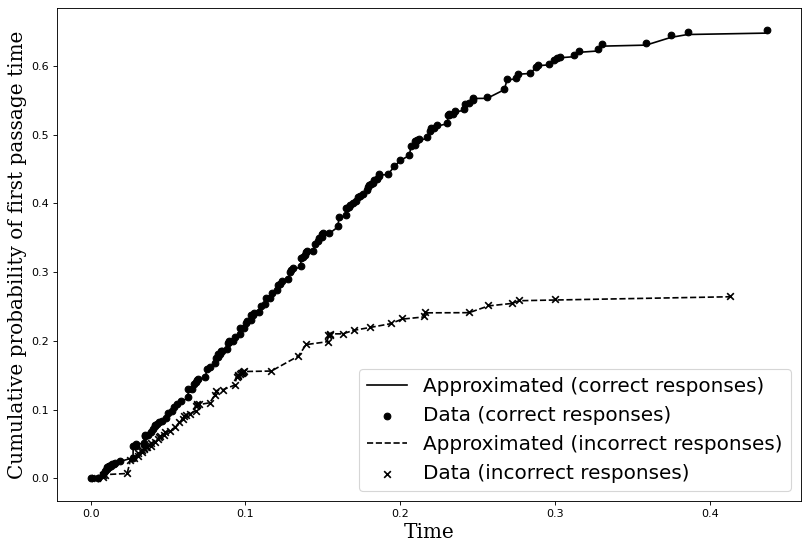

/tmp/ipython-input-3918826070.py:227: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F3.append(np.trapz(np.array(J3[:ii]), x=np.reshape(tspace3,(len(J3),1))[:ii],axis=0))
/tmp/ipython-input-3918826070.py:228: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F3_d.append(np.trapz(np.array(J3_d[:ii]), x=np.reshape(tspace3,(len(J3),1))[:ii],axis=0))
/tmp/ipython-input-3918826070.py:235: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F4.append(np.trapz(np.array(-J4[:ii]), x=np.reshape(tspace4,(len(J4),1))[:ii],axis=0))
/tmp/ipython-input-3918826070.py:236: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F4_d.append(np.trapz(np.array(J4_

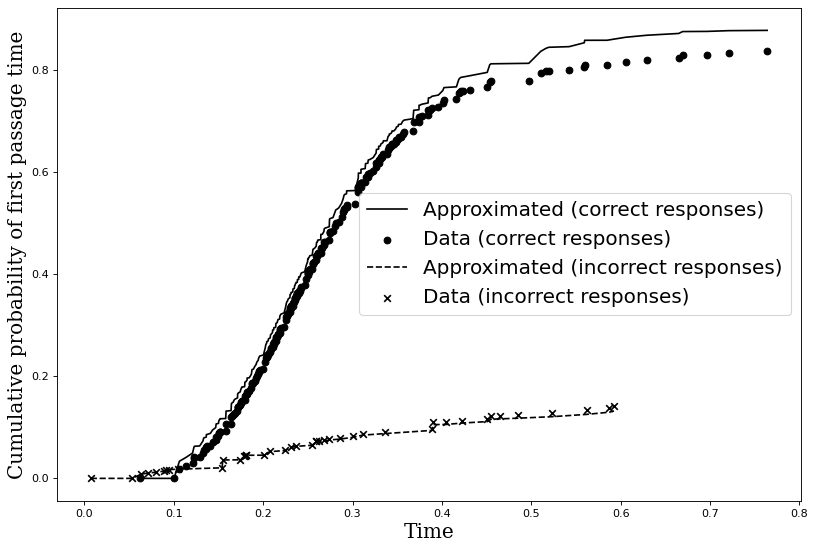

/tmp/ipython-input-3918826070.py:271: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F5.append(np.trapz(np.array(J5[:ii]), x=np.reshape(tspace5,(len(J5),1))[:ii],axis=0))
/tmp/ipython-input-3918826070.py:272: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F5_d.append(np.trapz(np.array(J5_d[:ii]), x=np.reshape(tspace5,(len(J5),1))[:ii],axis=0))
/tmp/ipython-input-3918826070.py:279: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F6.append(np.trapz(np.array(-J6[:ii]), x=np.reshape(tspace6,(len(J6),1))[:ii],axis=0))
/tmp/ipython-input-3918826070.py:280: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  F6_d.append(np.trapz(np.array(J6_

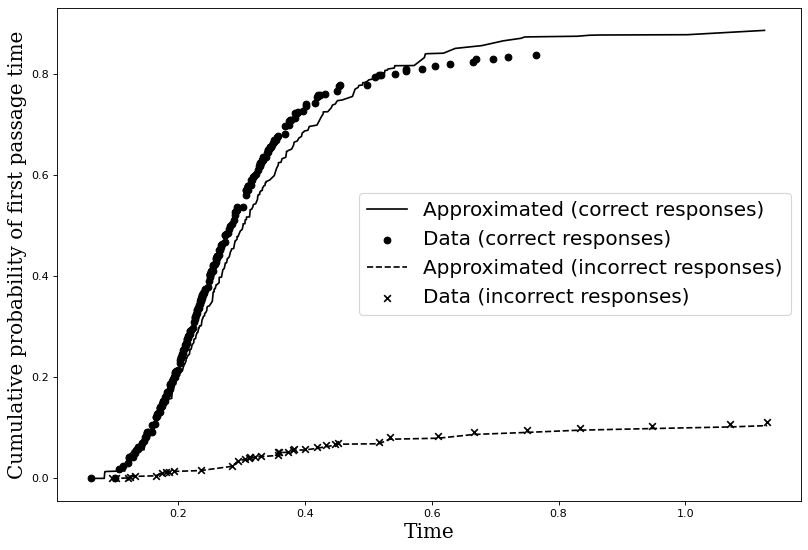

In [4]:
kde1 = gaussian_kde(rt1)
kde2 = gaussian_kde(rt2)
DTYPE='float32'

M = len(rt1)-1
tspace = rt1 - f_p_Identification.tt0f()
xspace = np.ones((M+1))*ub[1]
X = np.zeros((M+1,2))
X[:,0] = tspace
X[:,1] = xspace
X = tf.constant(X,DTYPE)
p_i = model(X)[:,0:1]

xspace1 = np.ones((M+1))*(ub[1]-0.02)
X1 = np.zeros((M+1,2))
X1[:,0] = tspace
X1[:,1] = xspace1
X1 = tf.constant(X1,DTYPE)
p_ii = model(X1)[:,0:1]

xspace2 = np.ones((M+1))*(ub[1]-0.04)
X2 = np.zeros((M+1,2))
X2[:,0] = tspace
X2[:,1] = xspace2
X2 = tf.constant(X2,DTYPE)
p_iii = model(X2)[:,0:1]
p_x = (3*p_i-4*p_ii+p_iii)/(2*0.02)

bt0 = f_p_Identification.a1f()- (f_p_Identification.a1f()*tf.reshape(tf.constant(tspace,dtype='float32'),[len(tspace),1]))/(2*f_p_Identification.t_inff1())
mu0 = f_p_Identification.lambda0f()/bt0 - (f_p_Identification.a1f()*(-f_p_Identification.a1f()/(2*f_p_Identification.t_inff1())))/bt0
J1 = mu0 * p_i - 0.5*(1/bt0)*p_x

M = len(rt2)-1
tspace = rt2 - f_p_Identification.tt0f()
xspace = np.ones((M+1))*lb[1]
X = np.zeros((M+1,2))
X[:,0] = tspace
X[:,1] = xspace
X = tf.constant(X,DTYPE)
p_i = model(X)[:,0:1]

xspace1 = np.ones((M+1))*(lb[1]+0.05)
X1 = np.zeros((M+1,2))
X1[:,0] = tspace
X1[:,1] = xspace1
X1 = tf.constant(X1,DTYPE)
p_ii = model(X1)[:,0:1]

xspace2 = np.ones((M+1))*(lb[1]+.1)
X2 = np.zeros((M+1,2))
X2[:,0] = tspace
X2[:,1] = xspace2
X2 = tf.constant(X2,DTYPE)
p_iii = model(X2)[:,0:1]
p_x = (-3*p_i+4*p_ii-p_iii)/(2*0.05)
bt0 = f_p_Identification.a1f()- (f_p_Identification.a1f()*tf.reshape(tf.constant(tspace,dtype='float32'),[len(tspace),1]))/(2*f_p_Identification.t_inff1())
mu0 = f_p_Identification.lambda0f()/bt0 - (-f_p_Identification.a1f()*(-f_p_Identification.a1f()/(2*f_p_Identification.t_inff1())))/bt0
J2 = mu0 * p_i - 0.5*(1/bt0)*p_x

M = len(rt3)-1
tspace = rt3 - f_p_Identification.tt0f()
xspace = np.ones((M+1))*ub[1]
X = np.zeros((M+1,2))
X[:,0] = tspace
X[:,1] = xspace
X = tf.constant(X,DTYPE)
p_i = model(X)[:,1:2]

xspace1 = np.ones((M+1))*(ub[1]-0.02)
X1 = np.zeros((M+1,2))
X1[:,0] = tspace
X1[:,1] = xspace1
X1 = tf.constant(X1,DTYPE)
p_ii = model(X1)[:,1:2]

xspace2 = np.ones((M+1))*(ub[1]-0.04)
X2 = np.zeros((M+1,2))
X2[:,0] = tspace
X2[:,1] = xspace2
X2 = tf.constant(X2,DTYPE)
p_iii = model(X2)[:,1:2]
p_x = (3*p_i-4*p_ii+p_iii)/(2*0.02)
bt0 = f_p_Identification.a2f()- (f_p_Identification.a2f()*tf.reshape(tf.constant(tspace,dtype='float32'),[len(tspace),1]))/(2*f_p_Identification.t_inff2())
mu0 = f_p_Identification.lambda0f()/bt0 - (f_p_Identification.a2f()*(-f_p_Identification.a2f()/(2*f_p_Identification.t_inff2())))/bt0
J3 = mu0 * p_i - 0.5*(1/bt0)*p_x

M = len(rt4)-1
tspace = rt4 - f_p_Identification.tt0f()
xspace = np.ones((M+1))*lb[1]
X = np.zeros((M+1,2))
X[:,0] = tspace
X[:,1] = xspace
X = tf.constant(X,DTYPE)
p_i = model(X)[:,1:2]

xspace1 = np.ones((M+1))*(lb[1]+0.05)
X1 = np.zeros((M+1,2))
X1[:,0] = tspace
X1[:,1] = xspace1
X1 = tf.constant(X1,DTYPE)
p_ii = model(X1)[:,1:2]

xspace2 = np.ones((M+1))*(lb[1]+.1)
X2 = np.zeros((M+1,2))
X2[:,0] = tspace
X2[:,1] = xspace2
X2 = tf.constant(X2,DTYPE)
p_iii = model(X2)[:,1:2]
p_x = (-3*p_i+4*p_ii-p_iii)/(2*0.05)
bt0 = f_p_Identification.a2f()- (f_p_Identification.a2f()*tf.reshape(tf.constant(tspace,dtype='float32'),[len(tspace),1]))/(2*f_p_Identification.t_inff2())
mu0 = f_p_Identification.lambda0f()/bt0 - (-f_p_Identification.a2f()*(-f_p_Identification.a2f()/(2*f_p_Identification.t_inff2())))/bt0
J4 = mu0 * p_i - 0.5*(1/bt0)*p_x

M = len(rt5)-1
tspace = rt5 - f_p_Identification.tt0f()
xspace = np.ones((M+1))*ub[1]
X = np.zeros((M+1,2))
X[:,0] = tspace
X[:,1] = xspace
X = tf.constant(X,DTYPE)
p_i = model(X)[:,2:3]

xspace1 = np.ones((M+1))*(ub[1]-0.02)
X1 = np.zeros((M+1,2))
X1[:,0] = tspace
X1[:,1] = xspace1
X1 = tf.constant(X1,DTYPE)
p_ii = model(X1)[:,2:3]

xspace2 = np.ones((M+1))*(ub[1]-0.04)
X2 = np.zeros((M+1,2))
X2[:,0] = tspace
X2[:,1] = xspace2
X2 = tf.constant(X2,DTYPE)
p_iii = model(X2)[:,2:3]
p_x = (3*p_i-4*p_ii+p_iii)/(2*0.02)
bt0 = f_p_Identification.a3f()- (f_p_Identification.a3f()*tf.reshape(tf.constant(tspace,dtype='float32'),[len(tspace),1]))/(2*f_p_Identification.t_inff3())
mu0 = f_p_Identification.lambda0f()/bt0 - (f_p_Identification.a3f()*(-f_p_Identification.a3f()/(2*f_p_Identification.t_inff3())))/bt0
J5 = mu0 * p_i - 0.5*(1/bt0)*p_x

M = len(rt6)-1
tspace = rt6 - f_p_Identification.tt0f()
xspace = np.ones((M+1))*lb[1]
X = np.zeros((M+1,2))
X[:,0] = tspace
X[:,1] = xspace
X = tf.constant(X,DTYPE)
p_i = model(X)[:,2:3]

xspace1 = np.ones((M+1))*(lb[1]+0.02)
X1 = np.zeros((M+1,2))
X1[:,0] = tspace
X1[:,1] = xspace1
X1 = tf.constant(X1,DTYPE)
p_ii = model(X1)[:,2:3]

xspace2 = np.ones((M+1))*(lb[1]+.04)
X2 = np.zeros((M+1,2))
X2[:,0] = tspace
X2[:,1] = xspace2
X2 = tf.constant(X2,DTYPE)
p_iii = model(X2)[:,2:3]
p_x = (-3*p_i+4*p_ii-p_iii)/(2*0.02)
bt0 = f_p_Identification.a3f()- (f_p_Identification.a3f()*tf.reshape(tf.constant(tspace,dtype='float32'),[len(tspace),1]))/(2*f_p_Identification.t_inff3())
mu0 = f_p_Identification.lambda0f()/bt0 - (-f_p_Identification.a3f()*(-f_p_Identification.a3f()/(2*f_p_Identification.t_inff3())))/bt0
J6 = mu0 * p_i - 0.5*(1/bt0)*p_x
J = [J1, J2, J3, J4, J5, J6]

tspace2 = rt2 - f_p_Identification.tt0f()
tspace1 = rt1 - f_p_Identification.tt0f()

kde1 = gaussian_kde(rt1)
kde2 = gaussian_kde(rt2)
DTYPE='float32'

M = len(rt1)-1

J1_d = len(rt1)*kde1(rt1)[:, np.newaxis]/(len(rt1)+len(rt2))

F1 = []
F1_d = []

for ii in range(len(J1)):
    F1.append(np.trapz(np.array(J1[:ii]), x=np.reshape(tspace1,(len(J1),1))[:ii],axis=0))
    F1_d.append(np.trapz(np.array(J1_d[:ii]), x=np.reshape(tspace1,(len(J1),1))[:ii],axis=0))

J2_d = len(rt2)*kde2(rt2)[:, np.newaxis]/(len(rt1)+len(rt2))

F2 = []
F2_d = []
for ii in range(len(J2)):
    F2.append(np.trapz(np.array(-J2[:ii]), x=np.reshape(tspace2,(len(J2),1))[:ii],axis=0))
    F2_d.append(np.trapz(np.array(J2_d[:ii]), x=np.reshape(tspace2,(len(J2),1))[:ii],axis=0))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8), dpi=80)

plt.plot(tspace1, F1, label='Approximated (correct responses)', color='black', linestyle='-')
plt.scatter(rt1 - f_p_Identification.tt0f(), F1_d, label='Data (correct responses)', color='black', marker='o')

plt.plot(tspace2, F2, label='Approximated (incorrect responses)', color='black', linestyle='--')
plt.scatter(rt2 - f_p_Identification.tt0f(), F2_d, label='Data (incorrect responses)', color='black', marker='x')

plt.xlabel('Time', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 18})
plt.ylabel('Cumulative probability of first passage time', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 18})

plt.legend(fontsize=18, loc='best')

plt.savefig("ex5-30.pdf", format="pdf", bbox_inches="tight")

plt.show()

tspace3 = rt3 - f_p_Identification.tt0f()
tspace4 = rt4 - f_p_Identification.tt0f()

kde3 = gaussian_kde(rt3)
kde4 = gaussian_kde(rt4)
DTYPE='float32'

J3_d = len(rt3)*kde3(rt3)[:, np.newaxis]/(len(rt3)+len(rt4))

F3 = []
F3_d = []

for ii in range(len(J3)):
    F3.append(np.trapz(np.array(J3[:ii]), x=np.reshape(tspace3,(len(J3),1))[:ii],axis=0))
    F3_d.append(np.trapz(np.array(J3_d[:ii]), x=np.reshape(tspace3,(len(J3),1))[:ii],axis=0))

J4_d = len(rt4)*kde4(rt4)[:, np.newaxis]/(len(rt3)+len(rt4))

F4 = []
F4_d = []
for ii in range(len(J4)):
    F4.append(np.trapz(np.array(-J4[:ii]), x=np.reshape(tspace4,(len(J4),1))[:ii],axis=0))
    F4_d.append(np.trapz(np.array(J4_d[:ii]), x=np.reshape(tspace4,(len(J4),1))[:ii],axis=0))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8), dpi=80)

plt.plot(tspace3, F3, label='Approximated (correct responses)', color='black', linestyle='-')
plt.scatter(rt3 - f_p_Identification.tt0f(), F3_d, label='Data (correct responses)', color='black', marker='o')

plt.plot(tspace4, F4, label='Approximated (incorrect responses)', color='black', linestyle='--')
plt.scatter(rt4 - f_p_Identification.tt0f(), F4_d, label='Data (incorrect responses)', color='black', marker='x')

plt.xlabel('Time', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 18})
plt.ylabel('Cumulative probability of first passage time', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 18})

plt.legend(fontsize=18, loc='best')

plt.savefig("ex5-31.pdf", format="pdf", bbox_inches="tight")

plt.show()

tspace5 = rt5 - f_p_Identification.tt0f()
tspace6 = rt6 - f_p_Identification.tt0f()

kde5 = gaussian_kde(rt5)
kde6 = gaussian_kde(rt6)
DTYPE='float32'

J5 = abs(J5)
J5_d = len(rt5)*kde5(rt5)[:, np.newaxis]/(len(rt5)+len(rt6))

F5 = []
F5_d = []

for ii in range(len(J5)):
    F5.append(np.trapz(np.array(J5[:ii]), x=np.reshape(tspace5,(len(J5),1))[:ii],axis=0))
    F5_d.append(np.trapz(np.array(J5_d[:ii]), x=np.reshape(tspace5,(len(J5),1))[:ii],axis=0))

J6_d = len(rt6)*kde6(rt6)[:, np.newaxis]/(len(rt5)+len(rt6))

F6 = []
F6_d = []
for ii in range(len(J6)):
    F6.append(np.trapz(np.array(-J6[:ii]), x=np.reshape(tspace6,(len(J6),1))[:ii],axis=0))
    F6_d.append(np.trapz(np.array(J6_d[:ii]), x=np.reshape(tspace6,(len(J6),1))[:ii],axis=0))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8), dpi=80)

plt.plot(tspace5, F5, label='Approximated (correct responses)', color='black', linestyle='-')
plt.scatter(rt3 - f_p_Identification.tt0f(), F3_d, label='Data (correct responses)', color='black', marker='o')

plt.plot(tspace6, F6, label='Approximated (incorrect responses)', color='black', linestyle='--')
plt.scatter(rt6 - f_p_Identification.tt0f(), F6_d, label='Data (incorrect responses)', color='black', marker='x')

plt.xlabel('Time', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 18})
plt.ylabel('Cumulative probability of first passage time', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 18})

plt.legend(fontsize=18, loc='best')

plt.savefig("ex5-32.pdf", format="pdf", bbox_inches="tight")

plt.show()